In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf

In [3]:
df = pd.read_csv('Sunspots.csv')

In [4]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3252 non-null   int64  
 1   Date                               3252 non-null   object 
 2   Monthly Mean Total Sunspot Number  3252 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.3+ KB


In [6]:
# Function to plot series
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.figure(figsize=(10,6))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Mean Sunspot Number")
    plt.grid(True)


Exploratory Data Analysis

<AxesSubplot:xlabel='Date', ylabel='Monthly Mean Total Sunspot Number'>

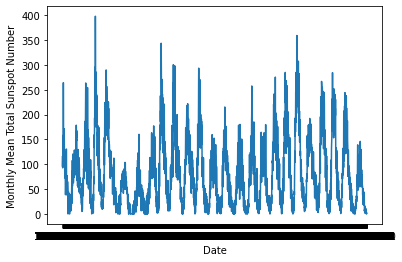

In [7]:
sns.lineplot(x='Date',y='Monthly Mean Total Sunspot Number',data=df)

In [8]:
#convert data set to timeseries

import csv
time_step = []
temp = []

with open('Sunspots.csv') as f:
    reader = csv.reader(f,delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        temp.append(float(row[2]))
        time_step.append(step)
        step +=1

series = np.array(temp)
time = np.array(time_step)

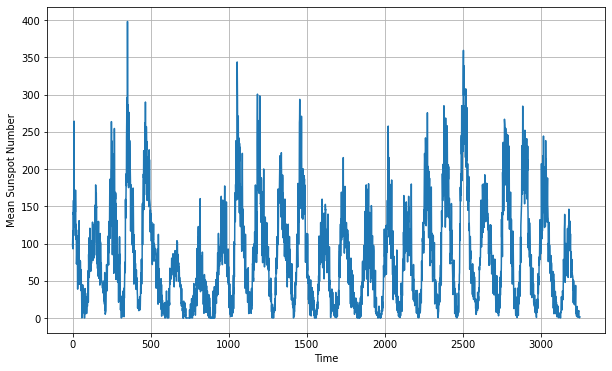

In [9]:
plot_series(time,series)

In [10]:
#splitting the data

split_time = 2500
train_time = time[:split_time]
x_train = series[:split_time]

valid_time = time[split_time:]
x_valid = series[split_time:]

In [11]:
 #Data preprocessing
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 5, strides=1, padding="same", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
])


model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
39/39 [==============================] - 7s 186ms/step - loss: 64.7138 - mae: 65.2081
Epoch 2/100
39/39 [==============================] - 7s 181ms/step - loss: 32.0153 - mae: 32.4941
Epoch 3/100
39/39 [==============================] - 7s 187ms/step - loss: 10.5627 - mae: 11.0187
Epoch 4/100
39/39 [==============================] - 7s 183ms/step - loss: 5.7839 - mae: 6.2347
Epoch 5/100
39/39 [==============================] - 7s 174ms/step - loss: 3.2169 - mae: 3.6394
Epoch 6/100
39/39 [==============================] - 7s 176ms/step - loss: 3.7463 - mae: 4.1908
Epoch 7/100
39/39 [==============================] - 7s 184ms/step - loss: 2.1382 - mae: 2.5467
Epoch 8/100
39/39 [==============================] - 8s 203ms/step - loss: 2.8029 - mae: 3.2367
Epoch 9/100
39/39 [==============================] - 7s 173ms/step - loss: 1.8497 - mae: 2.2509
Epoch 10/100
39/39 [==============================] - 7s 186ms/step - loss: 1.5195 - mae: 1.8992
Epoch 11/100
39/39 [=============

In [14]:
# Predict the result

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [15]:
# Evaluate the model using MAE
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17.740404

<AxesSubplot:>

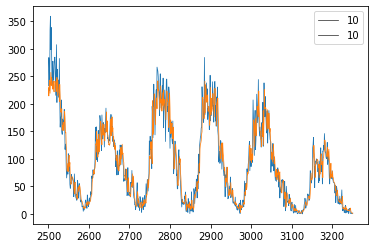

In [16]:
sns.lineplot(x=valid_time,y=x_valid,size=10)
sns.lineplot(x=valid_time,y=rnn_forecast,size=10)